<a href="https://colab.research.google.com/github/NileshPayghan/ML/blob/main/VGG_style_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 33.33 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [ ]:
!git clone https://github.com/akTwelve/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 979, done.
remote: Total 979 (delta 0), reused 0 (delta 0), pack-reused 979
Receiving objects: 100% (979/979), 137.72 MiB | 30.60 MiB/s, done.
Resolving deltas: 100% (570/570), done.


In [ ]:
!unzip /content/footimages.zip

Archive:  /content/footimages.zip
   creating: footimages/
   creating: footimages/train/
  inflating: footimages/train/5.jpg  
  inflating: footimages/train/2.jpg  
  inflating: footimages/train/1.jpg  
  inflating: footimages/train/4.jpg  
  inflating: footimages/train/3.jpg  
  inflating: footimages/train/Foot_Detector_json.json  
   creating: footimages/val/
  inflating: footimages/val/5.jpg    
  inflating: footimages/val/Foot_Detector_json.json  
  inflating: footimages/val/2.jpg    
  inflating: footimages/val/4.jpeg   
  inflating: footimages/val/1.jpg    
  inflating: footimages/val/3.jpg    


In [ ]:
cd /content/Mask_RCNN

/content/Mask_RCNN


In [ ]:
pwd

'/content/Mask_RCNN'

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt

In [ ]:
# Root directory of the project
ROOT_DIR = "/content/footimages"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + car and truck

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
############################################################
#  Dataset
############################################################

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "foot")
        # self.add_class("object", 2, "Truck")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open('/content/footimages/train/Foot_Detector_json.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"foot": 1}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/footimages", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/footimages", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=20,
                layers='heads')
			
				
				
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

train(model)	

objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot']
numids [1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot']
numids [1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot']
numids [1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot']
numids [1]
Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/footimages/logs/object20221115T1035/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_c

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20


In [ ]:
# cd Mask-RCNN-TF2/

/content/Mask-RCNN-TF2


In [ ]:
# !pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.5 MB 1.3 MB/s 
     |████████████████████████████████| 86.3 MB 54 kB/s 
     |████████████████████████████████| 377 kB 71.7 MB/s 
     |████████████████████████████████| 2.9 MB 45.7 MB/s 
     |████████████████████████████████| 449 kB 67.4 MB/s 
     |████████████████████████████████| 3.8 MB 49.0 MB/s 
     |████████████████████████████████| 50 kB 7.7 MB/s 
     |████████████████████████████████| 152 kB 74.7 MB/s 
     |████████████████████████████████| 1.6 MB 66.0 MB/s 
     |████████████████████████████████| 121 kB 95.2 MB/s 
     |████████████████████████████████| 154 kB 97.2 MB/s 
     |████████████████████████████████| 298 kB 90.8 MB/s 
     |████████████████████████████████| 83 kB 2.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=7f6548e6d65854667907b8adc8e2b10b2f7ad977484c46f6866a45b962e45b90
  Store

In [ ]:
# !python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn_tf2.egg-info
writing mask_rcnn_tf2.egg-info/PKG-INFO
writing dependency_links to mask_rcnn_tf2.egg-info/dependency_links.txt
writing top-level names to mask_rcnn_tf2.egg-info/top_level.txt
writing m

In [ ]:
# cd ../


/content


In [ ]:
# !git clone https://github.com/bnsreenu/python_for_microscopists.git

Cloning into 'python_for_microscopists'...
remote: Enumerating objects: 1356, done.
remote: Counting objects: 100% (517/517), done.
remote: Compressing objects: 100% (335/335), done.
remote: Total 1356 (delta 172), reused 483 (delta 169), pack-reused 839
Receiving objects: 100% (1356/1356), 109.39 MiB | 23.80 MiB/s, done.
Resolving deltas: 100% (443/443), done.


In [ ]:
# cd Mask-RCNN-TF2/

/content/Mask-RCNN-TF2


Train: 3


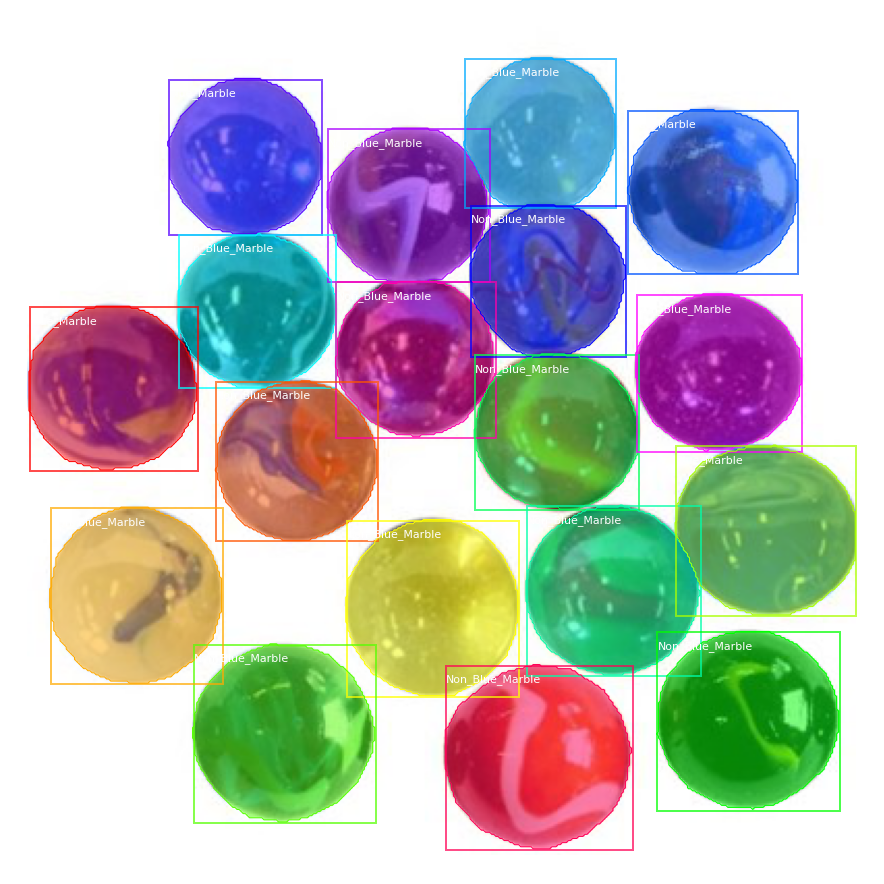


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# import os
# import sys
# import json
# import datetime
# import numpy as np
# import skimage.draw

# from mrcnn.visualize import display_instances
# from mrcnn.utils import extract_bboxes

# from mrcnn.utils import Dataset
# from matplotlib import pyplot as plt

# from mrcnn.config import Config
# from mrcnn.model import MaskRCNN


# from mrcnn import model as modellib, utils



# class CustomDataset(utils.Dataset):

#     def load_custom(self, dataset_dir, subset):
#         """Load a subset of the custom dataset.
#         dataset_dir: Root directory of the dataset.
#         subset: Subset to load: train or val
#         """
#         # Add classes according to the numbe of classes required to detect
#         self.add_class("custom", 1, "Blue_Marble")
#         self.add_class("custom",2,"Non_Blue_Marble")

#         # Train or validation dataset?
#         assert subset in ["train", "val"]
#         dataset_dir = os.path.join(dataset_dir, subset)

#         # Load annotations
#         # VGG Image Annotator (up to version 1.6) saves each image in the form:
#         # { 'filename': '28503151_5b5b7ec140_b.jpg',
#         #   'regions': {
#         #       '0': {
#         #           'region_attributes': {},
#         #           'shape_attributes': {
#         #               'all_points_x': [...],
#         #               'all_points_y': [...],
#         #               'name': 'polygon'}},
#         #       ... more regions ...
#         #   },
#         #   'size': 100202
#         # }
#         # We mostly care about the x and y coordinates of each region
#         # Note: In VIA 2.0, regions was changed from a dict to a list.
#         annotations = json.load(open(os.path.join(dataset_dir, "/content/Mask-RCNN-TF2/cocu/marbles_two_class_VGG_json_format.json")))
#         annotations = list(annotations.values())  # don't need the dict keys

#         # The VIA tool saves images in the JSON even if they don't have any
#         # annotations. Skip unannotated images.
#         annotations = [a for a in annotations if a['regions']]

#         # Add images
#         for a in annotations:
#             # Get the x, y coordinaets of points of the polygons that make up
#             # the outline of each object instance. These are stores in the
#             # shape_attributes (see json format above)
#             # The if condition is needed to support VIA versions 1.x and 2.x.
#             polygons = [r['shape_attributes'] for r in a['regions'].values()]
#             #labelling each class in the given image to a number

#             custom = [s['region_attributes'] for s in a['regions'].values()]
            
#             num_ids=[]
#             #Add the classes according to the requirement
#             for n in custom:
#                 try:
#                     if n['label']=='Blue_Marble':
#                         num_ids.append(1)
#                     elif n['label']=='Non_Blue_Marble':
#                         num_ids.append(2)
#                 except:
#                     pass

#             # load_mask() needs the image size to convert polygons to masks.
#             # Unfortunately, VIA doesn't include it in JSON, so we must read
#             # the image. This is only managable since the dataset is tiny.
#             image_path = os.path.join(dataset_dir, a['filename'])
#             image = skimage.io.imread(image_path)
#             height, width = image.shape[:2]

#             self.add_image(
#                 "custom",
#                 image_id=a['filename'],  # use file name as a unique image id
#                 path=image_path,
#                 width=width, height=height,
#                 polygons=polygons,
#                 num_ids=num_ids)

#     def load_mask(self, image_id):
#         """Generate instance masks for an image.
#        Returns:
#         masks: A bool array of shape [height, width, instance count] with
#             one mask per instance.
#         class_ids: a 1D array of class IDs of the instance masks.
#         """
#         # If not a custom dataset image, delegate to parent class.
#         image_info = self.image_info[image_id]
#         if image_info["source"] != "custom":
#             return super(self.__class__, self).load_mask(image_id)
#         num_ids = image_info['num_ids']	
#         #print("Here is the numID",num_ids)

#         # Convert polygons to a bitmap mask of shape
#         # [height, width, instance_count]
#         info = self.image_info[image_id]
#         mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
#                         dtype=np.uint8)
#         for i, p in enumerate(info["polygons"]):
#             # Get indexes of pixels inside the polygon and set them to 1
#             rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
#             mask[rr, cc, i] = 1

#         # Return mask, and array of class IDs of each instance. Since we have
#         # one class ID only, we return an array of 1s
#         num_ids = np.array(num_ids, dtype=np.int32)	
#         return mask, num_ids#.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32), 

#     def image_reference(self, image_id):
#         """Return the path of the image."""
#         info = self.image_info[image_id]
#         if info["source"] == "custom":
#             return info["path"]
#         else:
#             super(self.__class__, self).image_reference(image_id)

# dataset_train = CustomDataset()
# dataset_train.load_custom("marble_dataset/", "train") 
# dataset_train.prepare()
# print('Train: %d' % len(dataset_train.image_ids))



# # define image id
# image_id = 0
# # load the image
# image = dataset_train.load_image(image_id)
# # load the masks and the class ids
# mask, class_ids = dataset_train.load_mask(image_id)

# # display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# # dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# # extract bounding boxes from the masks
# bbox = extract_bboxes(mask)
# # display image with masks and bounding boxes
# display_instances(image, bbox, mask, class_ids, dataset_train.class_names)


# # define a configuration for the model
# class MarbleConfig(Config):
# 	# define the name of the configuration
# 	NAME = "marble_cfg"
# 	# number of classes (background + blue marble + non-Blue marble)
# 	NUM_CLASSES = 1 + 2
# 	# number of training steps per epoch
# 	STEPS_PER_EPOCH = 100
#     #DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
# # prepare config
# config = MarbleConfig()
# config.display() 




# ROOT_DIR = os.path.abspath("./")
# # Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
# # Directory to save logs and trained model
# DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# # Path to trained weights file
# COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "coco_weights/mask_rcnn_coco.h5")

In [ ]:
# !git clone https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

Cloning into 'mask_rcnn_coco.h5'...
remote: Not Found
fatal: repository 'https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5/' not found


In [ ]:
# # define the model
# model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
# # load weights (mscoco) and exclude the output layers
# model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# # train weights (output layers or 'heads')
# model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')

Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/pytho

KeyboardInterrupt: ignored

In [ ]:
# !pip install gdown
import gdown
url = "https://drive.google.com/uc?id=1SWVDHmcQjGykZn1mPAf7pwY7BTUCYK96"
output = "Mask Rcnn.zip"
gdown.download(url, output, quiet=False)
!unzip './Mask Rcnn.zip'

Downloading...
From: https://drive.google.com/uc?id=1SWVDHmcQjGykZn1mPAf7pwY7BTUCYK96
To: /content/Mask Rcnn.zip
100%|██████████| 480M/480M [00:04<00:00, 108MB/s]


Archive:  ./Mask Rcnn.zip
   creating: Final Mask RCNN/
   creating: Final Mask RCNN/.ipynb_checkpoints/
  inflating: Final Mask RCNN/.ipynb_checkpoints/custom-checkpoint.ipynb  
  inflating: Final Mask RCNN/custom-mask-rcnn-tf2.ipynb  
   creating: Final Mask RCNN/dataset/
   creating: Final Mask RCNN/dataset/train/
  inflating: Final Mask RCNN/dataset/train/img_000014.jpg  
  inflating: Final Mask RCNN/dataset/train/img_000015.jpg  
  inflating: Final Mask RCNN/dataset/train/img_000016.jpg  
  inflating: Final Mask RCNN/dataset/train/img_000017.jpg  
  inflating: Final Mask RCNN/dataset/train/img_000018.jpg  
  inflating: Final Mask RCNN/dataset/train/img_000019.jpg  
  inflating: Final Mask RCNN/dataset/train/img_000020.jpg  
  inflating: Final Mask RCNN/dataset/train/img_000021.jpg  
  inflating: Final Mask RCNN/dataset/train/img_000022.jpg  
  inflating: Final Mask RCNN/dataset/train/train_json.json  
   creating: Final Mask RCNN/dataset/val/
  inflating: Final Mask RCNN/dataset/v

In [ ]:
%cd Final Mask RCNN

/content/Final Mask RCNN


In [ ]:
!unzip footimages.zip

Archive:  footimages.zip
   creating: footimages/
   creating: footimages/train/
  inflating: footimages/train/5.jpg  
  inflating: footimages/train/2.jpg  
  inflating: footimages/train/1.jpg  
  inflating: footimages/train/4.jpg  
  inflating: footimages/train/3.jpg  
  inflating: footimages/train/Foot_Detector_json.json  
   creating: footimages/val/
  inflating: footimages/val/5.jpg    
  inflating: footimages/val/Foot_Detector_json.json  
  inflating: footimages/val/2.jpg    
  inflating: footimages/val/4.jpeg   
  inflating: footimages/val/1.jpg    
  inflating: footimages/val/3.jpg    


In [ ]:
!unzip logs.zip

Archive:  logs.zip
   creating: logs/
   creating: logs/object20221116T0912/
   creating: logs/object20221116T0912/plugins/
  inflating: logs/object20221116T0912/events.out.tfevents.1668590050.5ac94559efd0  
  inflating: logs/object20221116T0912/mask_rcnn_object_0002.h5  
  inflating: logs/object20221116T0912/events.out.tfevents.1668590181.5ac94559efd0.profile-empty  
  inflating: logs/object20221116T0912/mask_rcnn_object_0001.h5  
   creating: logs/object20221116T0912/plugins/profile/
   creating: logs/object20221116T0912/plugins/profile/2022_11_16_09_16_21/
  inflating: logs/object20221116T0912/plugins/profile/2022_11_16_09_16_21/5ac94559efd0.trace.json.gz  
  inflating: logs/object20221116T0912/plugins/profile/2022_11_16_09_16_21/5ac94559efd0.xplane.pb  
  inflating: logs/object20221116T0912/plugins/profile/2022_11_16_09_16_21/5ac94559efd0.tensorflow_stats.pb  
  inflating: logs/object20221116T0912/plugins/profile/2022_11_16_09_16_21/5ac94559efd0.overview_page.pb  
  inflating: logs

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt

In [ ]:
# Root directory of the project
ROOT_DIR = "Final Mask RCNN"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "/content/Final Mask RCNN/mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 3

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + net and table

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 20

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

############################################################
#  Dataset
############################################################


In [ ]:
import warnings
warnings.filterwarnings('ignore')
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "foot")
        # self.add_class("object", 2, "net")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        if subset == 'train':
            annotations1 = json.load(open('/content/Final Mask RCNN/footimages/train/Foot_Detector_json.json'))
        else:
            annotations1 = json.load(open('/content/Final Mask RCNN/footimages/val/Foot_Detector_json.json'))
        
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"foot": 1}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

def train(model): 
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/Final Mask RCNN/footimages", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/Final Mask RCNN/footimages", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=15,
                layers='heads')
			
				
				
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

train(model)			

objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot']
numids [1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot']
numids [1]
objects: ['foot']
numids [1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot']
numids [1]
objects: ['foot']
numids [1]
objects: ['foot', 'foot']
numids [1, 1]
Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: Final Mask RCNN/logs/object20221116T1325/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (Time

In [ ]:


import shutil
output_filename = 'logs'
dir_name = '/content/Final Mask RCNN/Final Mask RCNN'
shutil.make_archive(output_filename, 'zip', dir_name)

'/content/Final Mask RCNN/logs.zip'

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [ ]:
#import custom

# Root directory of the project
ROOT_DIR = "/content/Final Mask RCNN/logs"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = "/content/Final Mask RCNN/logs/object20221116T0912/mask_rcnn_object_0002.h5"   # change it

In [ ]:
# %cd ..
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # Background + Car and truck

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 2

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9



In [ ]:
# Code for Customdataset class. Same code is present in custom.py file also
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "foot")
        # self.add_class("object", 2, "net")


        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        if subset == 'train':
            
            annotations1 = json.load(open('/content/Final Mask RCNN/footimages/train/Foot_Detector_json.json'))

        else:
            annotations1 = json.load(open('/content/Final Mask RCNN/footimages/val/Foot_Detector_json.json'))
            
        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"foot": 1}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):

        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [ ]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "/content/Final Mask RCNN/footimages"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

In [ ]:
# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "/content/Final Mask RCNN/footimages"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['foot']
numids [1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot']
numids [1]
objects: ['foot']
numids [1]
objects: ['foot', 'foot']
numids [1, 1]
Images: 5
Classes: ['BG', 'foot']


In [ ]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/Final Mask RCNN/logs/object20221116T0912/mask_rcnn_object_0002.h5
Re-starting from epoch 2


Images: 5
Classes: ['BG', 'foot']
Processing 1 images
image                    shape: (960, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


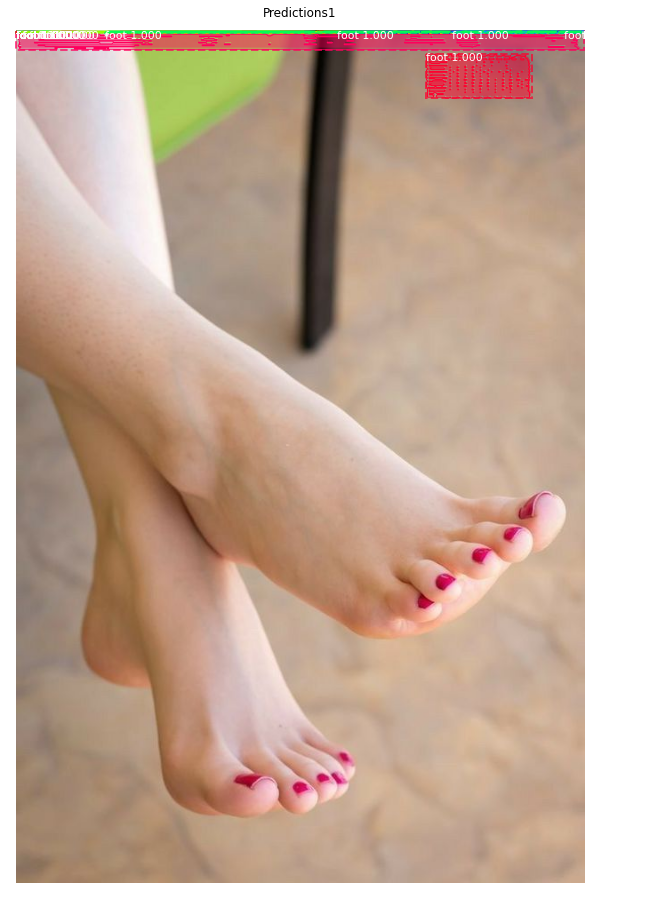

In [ ]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# This is for predicting images which are not present in dataset
path_to_new_image = '/content/Final Mask RCNN/footimages/val/2.jpg'
image1 = cv2.imread(path_to_new_image)
image1 = cv2.cvtColor(image1 , cv2.COLOR_BGR2RGB)
# Run object detection
#print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")


In [ ]:
# Code for Customdataset class. Same code is present in custom.py file also
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "foot")
        # self.add_class("object", 2, "Truck")


        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open('/content/Final Mask RCNN/footimages/train/Foot_Detector_json.json'))

        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"foot": 1}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):

        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [ ]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "/content/Final Mask RCNN/footimages"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

In [ ]:
# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "/content/Final Mask RCNN/footimages"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot']
numids [1]
objects: ['foot', 'foot']
numids [1, 1]
objects: ['foot']
numids [1]
Images: 5
Classes: ['BG', 'foot']


In [ ]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [ ]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/Final Mask RCNN/logs/object20221116T0912/mask_rcnn_object_0002.h5
Re-starting from epoch 2


Images: 5
Classes: ['BG', 'foot']
Processing 1 images
image                    shape: (1800, 1200, 3)       min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1800.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


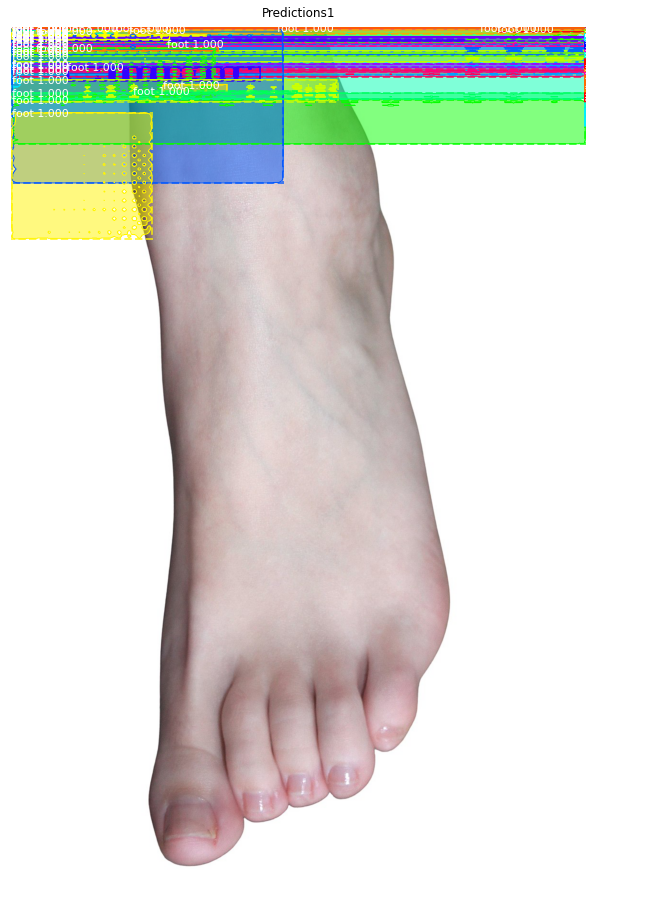

In [ ]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# This is for predicting images which are not present in dataset
path_to_new_image = '/content/Final Mask RCNN/footimages/train/1.jpg'
image1 = mpimg.imread(path_to_new_image)

# Run object detection
#print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")